# Introduction to Principal Component Analysis

In this section, we will begin exploring multivariate statistical analysis. But before we jump into the mathematics of **principal component analysis (PCA)**, we will take a look at an example that will help familiar us with the fundamentals of PCA.

The example that we will look at is an analysis of tropical Pacific sea surface temperature (SST) and what we will find  is that PCA reveals the signature of the [El Niño / Southern Oscillation (ENSO)](http://iri.columbia.edu/our-expertise/climate/enso/) phenomenon without any prior knowledge of ENSO.

In [1]:
# import packages
from netCDF4 import Dataset
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rc('font',size=14) #set default font size and weight for plots

Now, let's read in some SST data. Here we are using the [Extended Reconstructed Sea Surface Temperature data set](https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v4). We will access it using the [OpenDAP data server architecture](https://earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap).

In [2]:
# the data we will use is described here
# http://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v5
# It is stored in the IRI data library
iri_url = "http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/"
T_convert = "T/[(days)(since)(1960-01-01)]sconcat/streamgridunitconvert/"

# complete url
url = iri_url + T_convert + "dods"

nc = Dataset(url)
sst = nc.variables['sst'][:]
lat = nc.variables['Y'][:]
lon = nc.variables['X'][:]
time = nc.variables['T'][:]

Note that the dimensions are: `T` = time, `X` = longitude, `Y` = latitude and `zlev` = depth and the variable is `sst`. 

Note that there is a depth dimension, `zlev`; however this only has one element, the surface.

So, we have a 4-dimensional (3 if we don't count `zlev`) `sst` variable on an evenly-spaced horizontal grid and each grid has a corresponding time series of length 2002.

Let's make a plot of SST for `zlev = 0` and `T = 0`, just to get a sense of what the data looks like.

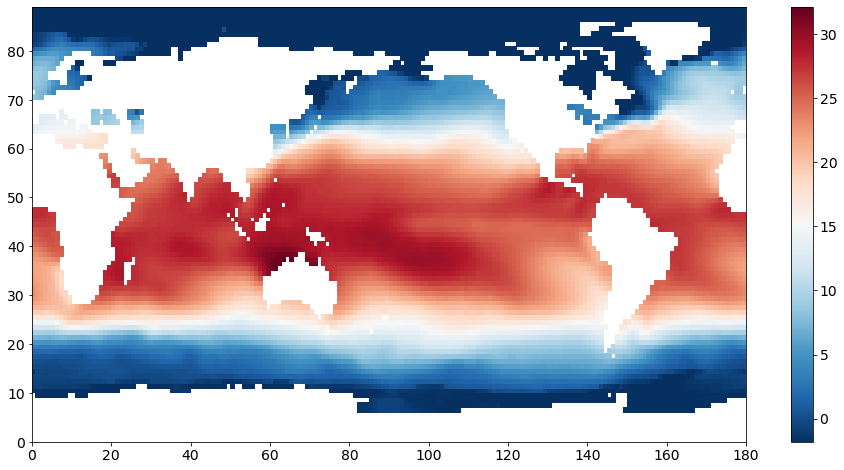

In [3]:
# make an exploratory plot
plt.figure(figsize=(16,8))
plt.pcolormesh(sst[0,0,:,:],cmap='RdBu_r')
plt.colorbar()
plt.show()

We see a clear pattern of warmer SSTs near the equator and cooler SSTs in the mid- to high-latitudes. The continents are not plotted as these grid points have missing values represented by "NaNs" (not-a-number).

## Niño3.4 Index

In this example we are going to construct the ENSO index in two different ways. First, we will construct it following the [Niño3.4 Index](http://www.cgd.ucar.edu/cas/catalog/climind/TNI_N34/index.html#Sec5) definition. The Niño3.4 Index is a commonly used metric of ENSO variability. The recipe for calculating it is:

1. Compute area averaged total SST from Niño3.4 region (5N-5S, 170W-120W).
2. Compute monthly climatology (1950-1979) for area averaged total SST from Niño 3.4 region, and subtract climatology from area averaged total SST time series to obtain anomalies.
3. Smooth the anomalies with a 5-month running mean.
4. Standardize the smoothed Niño3.4 by its standard deviation over the climatological period 1950-1979.

### Step 1: Isolate Niñ3.4 region and compute area average

In [4]:
# The Niño3.4 Region is bounded by 170°W-120°W (190-240°E) and 5°S- 5°N.
# extract this region and compute area average
sst_n34 = np.mean(sst[:,0,41:48,95:121],axis=1)
sst_n34 = np.mean(sst_n34,axis=1)

### Step 2: Compute SST anomaly

The SST anomaly that we want is relative to the 1950-1979 climatology. So, first we compute this 12-month climatology...

In [5]:
# compute 1950-1979 monthly climatology
sst_n34_clim = np.reshape(sst_n34[96*12:126*12],(30,12)).mean(axis=0)
print(sst_n34_clim.shape)

(12,)


...and then we substract it.

In [6]:
# reshape to compute anomaly (drop the last 10 months so that we have an integer number of years)
sst_n34_reshape = np.reshape(sst_n34[:-10],(166,12))

# calculate monthly anomaly
sst_n34_anom = sst_n34_reshape - sst_n34_clim

# reshape anomaly back to long time series
sst_n34_anom = np.reshape(sst_n34_anom,(166*12))

### Step 3: Apply 5-month running-mean



The next step is to apply a 5-month running-mean smoothing. We will use the `np.convolve` function to do this.

In [7]:
# smooth with 5-month running mean
sst_n34_smooth = np.convolve(sst_n34_anom,np.ones(5)/5.0,'same')

### Step 4: Standardize by the standard deviation 

Finally, we standardize the smoothed time series by the standard deviation of the 1950-1979 climatology.

In [8]:
# now normalize by standard deviation fo 1950-1979 climatology
n34_index = sst_n34_smooth / sst_n34_smooth[96*12:126*12].std()

Let's plot the time series.

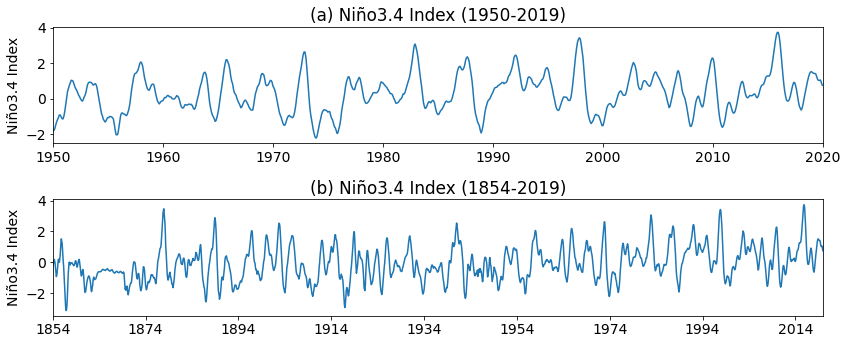

In [9]:
## plot the Nino 3.4 Index

# First we just plot the fist 70 years
fig = plt.figure(figsize=(12,5))
plt.subplot(211)
plt.plot(n34_index[96*12:])
plt.ylabel('Niño3.4 Index')
plt.xticks(np.arange(0,852,10*12),['1950','1960','1970','1980','1990','2000','2010','2020'])
plt.xlim(0,840)
plt.title("(a) Niño3.4 Index (1950-2019)")
plt.tight_layout()

# Next we just plot the entire time series
plt.subplot(212)
plt.plot(n34_index)
plt.ylabel('Niño3.4 Index')
plt.xticks(np.arange(0,1992,20*12),['1854','1874','1894','1914','1934','1954','1974','1994','2014'])
plt.xlim(0,1992)
plt.title("(b) Niño3.4 Index (1854-2019)")
plt.tight_layout()

## PCA of Tropical Pacific SST: Setting up the Problem

Now we will perform a principal component analysis (PCA) on the tropical Pacific SST. Our goal is to see if we can recreate the Niñ3.4 Index time series above through PCA. Some of the code is hidden because at this stage we are not going to worry about how to do PCA, but rather, what PCA represents. 

Before we do the PCA, we will take a look at the spatial structure of the data. Let's pick a larger region so that we can more easily see what is going on.

In [10]:
# extract a slightly larger spatial region in space (-30S-30N, 120E-300E) and a restricted time interval (1950-2019)
sst_pac = sst[12*96:-10,0,29:59,60:150]

The output of PCA is a set of pairs of spatial patterns (EOFs) and time series (PCs). The size of the set depends on the size of the original data. The pairs are ordered in terms of variance explained, i.e. the first pair explains the largest fraction of variance in the data, the second pair explains the second largest fraction of variance, and so on. 

If we leave the seasonal cycle in our data, the seasonal cycle will likely emerge as the largest source of variance. Let's see if this is what we get.

First, we will compute an anomaly. We will NOT subtract a monthly climatology (we want to see the seasonal cycle emerge from our analysis) - instead just subtract the time mean.

In [11]:
# compute an anomaly
ssta_pac = sst_pac - sst_pac.mean(axis=0)

To visualize these anomalies, we can plot the data on a map by slicing just one one element in time.

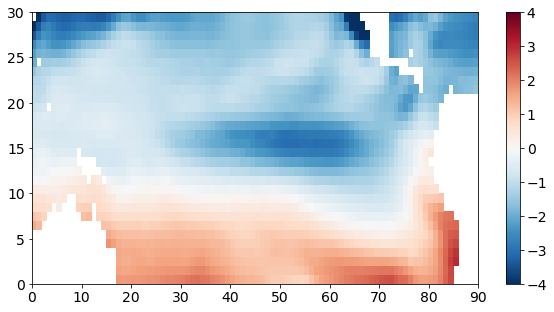

In [12]:
# visualize the region we're working with
plt.figure(figsize=(10,5))
plt.pcolormesh(ssta_pac[0,:,:],cmap = "RdBu_r")
plt.clim(-4,4)
plt.colorbar()

Note that I haven't labelled the x- and y-axes appropriately here. The x- and y-tick labels just show the number of elements. In subsequent sections, we will use a python package called `cartopy` to plot nice maps.

If we do remove the monthly climatology, how does the above anomaly plot change? 

In [13]:
# Just to compare, let's subtract the seasonal cycle
sst_pac_clim = np.reshape(sst_pac,(70,12,sst_pac.shape[1],sst_pac.shape[2])).mean(axis=0)
ssta_pac_noseasons = np.reshape(sst_pac,(70,12,sst_pac.shape[1],sst_pac.shape[2])) - sst_pac_clim

# reshape back to time series
ssta_pac_noseasons = np.reshape(ssta_pac_noseasons,(70*12,sst_pac.shape[1],sst_pac.shape[2]))

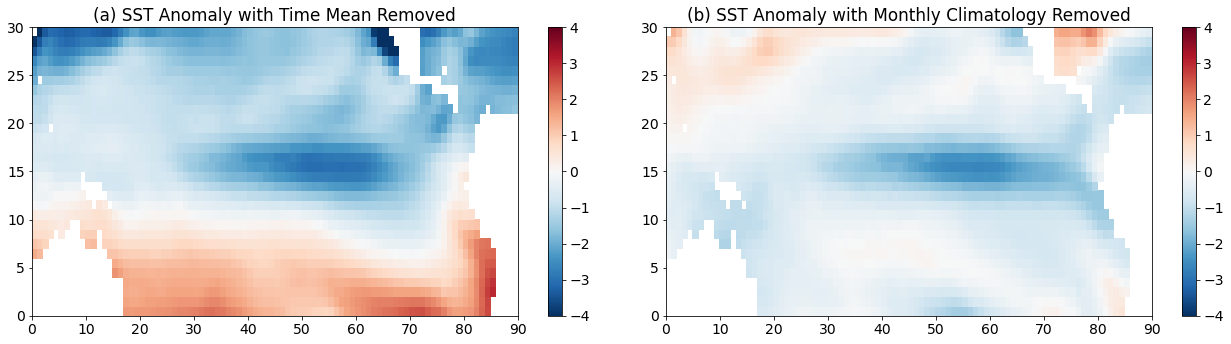

In [14]:
# visualize the region we're working with
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.pcolormesh(ssta_pac[0,:,:],cmap = "RdBu_r")
plt.clim(-4,4)
plt.colorbar()
plt.title("(a) SST Anomaly with Time Mean Removed")

plt.subplot(1,2,2)
plt.pcolormesh(ssta_pac_noseasons[0,:,:],cmap = "RdBu_r")
plt.clim(-4,4)
plt.colorbar()
plt.title("(b) SST Anomaly with Monthly Climatology Removed")
plt.tight_layout()

We see some similar features between the two plots, but we also see that the warm southern hemisphere and the cold northern hemisphere is reduced, suggesting that this part of the pattern is associated with the seasonal cycle.

PCA should identify sources of variance, so a good place to start to explore the variance in our data is to plot the standard deviation for each grid point.

In [15]:
# Now, let's look at the standard deviation of our data as a function of lat and lon
ssta_pac_std = np.std(ssta_pac,axis=0)
ssta_pac_std_noseasons = np.std(ssta_pac_noseasons,axis=0)

We can plot the standard deviation on a map.

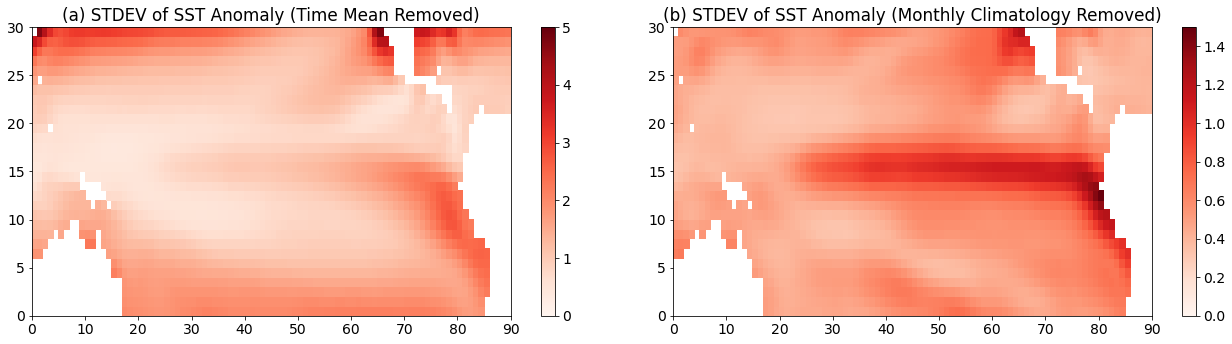

In [16]:
# visualize the variability of the region we're working with
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.pcolormesh(ssta_pac_std,cmap='Reds')
plt.title("(a) STDEV of SST Anomaly (Time Mean Removed)")
plt.clim(0,5)
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(ssta_pac_std_noseasons,cmap='Reds')
plt.title("(b) STDEV of SST Anomaly (Monthly Climatology Removed)")
plt.clim(0,1.5)
plt.colorbar()
plt.tight_layout()

Notice that the patterns look quite different (I have also set different colorbar limits in the different panels). Panel (a) shows low values for standard deviation in the tropics while in panel (b) the largest vales of standard deviation are in the tropics.

## PCA: Step-by-step

Now, that we have our SST anomaly as a function of time, latitude and longitude for our region of interest, there are a few more steps that we have to go through to prepare the data for PCA.

### Step 1: Missing values

The python PCA function will not work with "NaN" values, so we are going to fill these with zeros. When we fill these with zeros, these will not contribute to the variance as the mean of our *anomaly* data is also zero.

In [17]:
# fill in missing values with zeros
a = np.ma.masked_invalid(ssta_pac).filled(0.)

### Step 2: Standardize data

Sometimes, we will want to standardize our data before beginning our EOF analysis. This step is not required and whether or not we include this step depends on our data. We will discuss this in more detail later in this section. For now, we will standardize our data.

In [18]:
# standardize the anomalies
a = (a - a.mean())/a.std()
print(a.mean(), a.std())

7.739527224081797e-17 1.0


The next few cells of code will be hidden. We will focus on the output of PCA. But, come back to this page after you have worked through the next two sections to revisit what is going on.

### Step 3: Convert 3D array to 2D matrix

The next step is to convert our 3D array into a 2D matrix, so that we can perform matrix operations. We do this by combining all the spatial dimensions together.

Let's remind ourselves of the shape of our data.

In [19]:
print(a.shape)

(840, 30, 90)


In [20]:
# We have a 3-D array. We need to convert it to 2-D. 
# So, we combine the two spatial dimensions into one.

# Reshape the array to have one time dimension, one space dimension
Nt, Ny, Nx = a.shape
a.shape = (Nt, Ny*Nx)

Let's check the shape of our data now.

In [21]:
print(a.shape)

(840, 2700)


### Step 4: Calculate covariance matrix

Now, we can calculate the covariance matrix. Since our data is standardized, we will actually be computing the correlation matrix.

In [22]:
# calculate covariance matrix
C = np.cov(a, rowvar = False)
print(C.shape)

(2700, 2700)


### Step 5: Perform eigenanalysis of covariance matrix

In [23]:
# eigenanalysis
LAM, E = np.linalg.eig(C)

The output of the eigenanalysis is a set of spatial patterns (EOFs). We then calculate the corresponding time series' (PCs). Here, we will just take a look at the first two pairs of EOFs and PCs.

In [24]:
# extract and reshape spatial patterns and calculate PCs
sst_pat1 = np.reshape(np.real(E[:,0]), (Ny,Nx))
sst_ts1  = np.dot(a,np.real(E[:,0]))
#standardize PC time series
sst_ts1 = (sst_ts1 - np.mean(sst_ts1))/np.std(sst_ts1)


sst_pat2 = np.reshape(np.real(E[:,1]), (Ny,Nx))
sst_ts2  = np.dot(a,np.real(E[:,1]))
#standardize PC time series
sst_ts2 = (sst_ts2 - np.mean(sst_ts2))/np.std(sst_ts2)

Once we have calculated our set of pairs of spatial patterns (EOFs) and time series' (PCs), we can plot them to visualize what is going on. 

Recall that we hypothesized that the first EOF and PC should correspond to the seasonal cycle? Is this what we see below?

(0.0, 840.0)

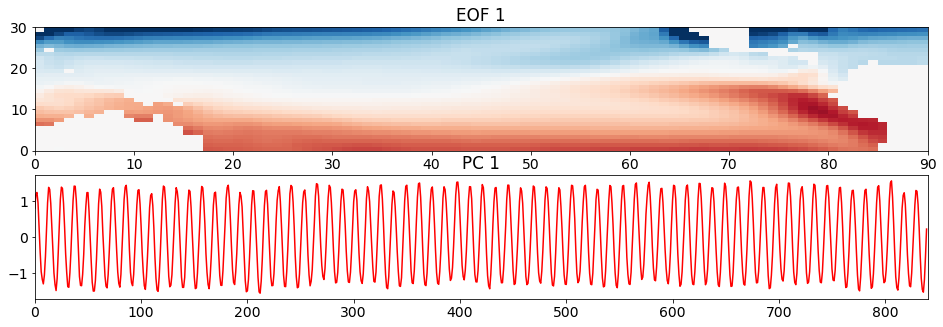

In [25]:
# look at first EOF patterns and PC time series
plt.figure(figsize=(16,5))
plt.subplot(211)
plt.pcolormesh(sst_pat1, cmap='RdBu_r')
plt.clim(-0.05,0.05)
plt.title('EOF 1')

plt.subplot(212)
plt.plot(sst_ts1,'r')
plt.clim(-0.05,0.05)
plt.title('PC 1')
plt.xlim(0,840)

The plot of the time series clearly shows the seasonal cycle emerge from the data. In plot of the spatial pattern, red colours correspond to positive anomalies and blue colours correspond to negative anomalies. Thus, it looks like the spatial pattern is showing us summer in the southern hemisphere and winter in the northern hemisphere. 

If we compare this spatial pattern to the standard deviation of the SST anomaly with the time mean removed, we see some similar features, but the standard deviation is a squared quantity, so we are missing some important aspects of the pattern - that when the SST is anomalously warm in the south, it is anomalously cold in the north.

And there is a specific connection between the spatial pattern and the time series: the spatial pattern corresponds to the positive phase of the time series, i.e. when the time series equals a value of +1, the spatial pattern looks like that in the above plot; when the time series equals a value of -1, the spatial pattern looks like -1 times the spatial pattern in the above plot.

Let's move on to the second pair of EOFs and PCs.

(0.0, 840.0)

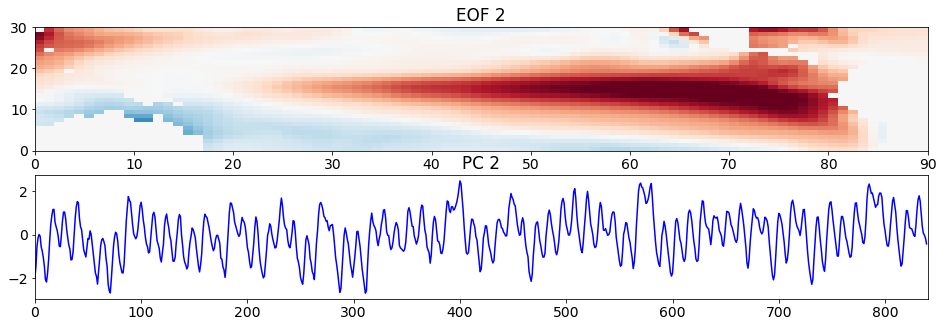

In [26]:
# look at second EOF patterns and PC time series
plt.figure(figsize=(16,5))
plt.subplot(211)
plt.pcolormesh(sst_pat2, cmap='RdBu_r')
plt.clim(-0.05,0.05)
plt.title('EOF 2')

plt.subplot(212)
plt.plot(sst_ts2, 'b')
plt.title('PC 2')
plt.xlim(0,840)

What do you see? Compare the time series here with that of the Niño3.4 Index we calculated at the beginning of the page. They should look fairly similar. Thus, the second pattern corresponds to the SST anomaly pattern associated with ENSO. In particular, the pattern is showing the El Niño pattern. This pattern should look somewhat similar to the standard deviation of the SST anomaly with the monthly climatology removed.

A value of +1 in the PC time series corresponds to a pattern of the magnitude and sign shown above, El Niño. A value of -1 corresponds approximately to a La Niña pattern, which is -1 times the spatial pattern above.

Note that in nature each El Niño and La Niña event are different - they do not always look like the above pattern. These EOFs and PC time series are statistical, but often describe physical phenomena.

To convince ourselves that our statistical PCA is giving us something resembling the Niño3.4 Index, let's plot the PC time series and the Niño3.4 Index together.

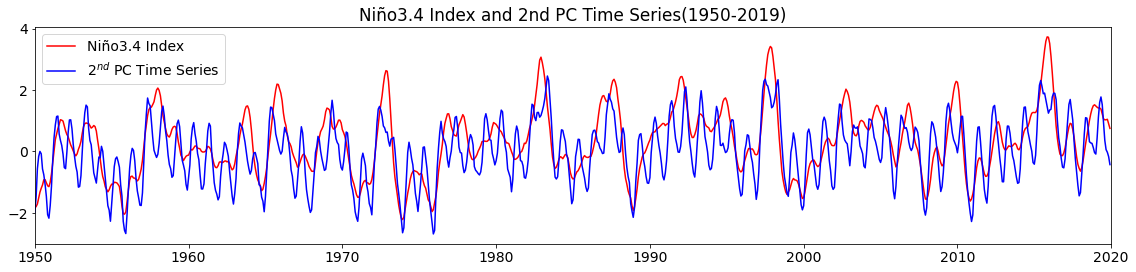

In [27]:
# plot second PC time series and Niño3.4 Index
plt.figure(figsize=(16,4))
plt.plot(n34_index[96*12:],'r',label='Niño3.4 Index')
plt.plot(sst_ts2, 'b', label='2$^{nd}$ PC Time Series')
plt.xticks(np.arange(0,852,10*12),['1950','1960','1970','1980','1990','2000','2010','2020'])
plt.title("Niño3.4 Index and 2nd PC Time Series(1950-2019)")
plt.xlim(0,840)
plt.legend()
plt.tight_layout()

They look pretty similar, although the Niño3.4 Index is smoother due to the 5-month running-mean that we applied.

Although the results of the PCA of tropical Pacific SST may not be entirely surprising, the beauty of PCA is that with a single operation, we simultaneously generate spatial patterns and their corresponding time series. And for large, noisy data sets, these patterns may not be quite as obvious as they were for tropical Pacific SST.